# Graphics and tables

Graphics and tables for the paper.

## Setup

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from pathlib import Path

In [2]:
plt.style.use('science')

## Experiments

In [3]:
# Copied and pasted from Google Sheets
all_experiments = """2023-06-15-19-20-21
2023-06-18-21-50-54"""
all_experiments = all_experiments.split("\n")
all_experiments = [x for x in all_experiments if x != ""]
all_experiments = set(all_experiments)
all_experiments

{'2023-06-15-19-20-21', '2023-06-18-21-50-54'}

## Data loading

In [4]:
all_results = dict()
experiments = []

for item in Path("..").glob("data/experiments/*"):
    if item.is_dir() and item.name in all_experiments:
        for experiment in item.glob("*"):
            if experiment.is_dir():
                if (experiment / "results.jsonl").exists():
                    experiment_name = experiment.name
                    print(experiment_name)
                    experiments.append(experiment_name)
                    all_results[experiment_name] = []
                    with open(experiment / "results.jsonl", 'r') as f:
                        for line in f:
                            all_results[experiment_name].append(json.loads(line))

hatexplain_all-lime-bert_128_fine_tuned-2
hatexplain_all-lime-bert_attention-2


## Data checking

In [5]:
# Assert experiments are unique
assert len(experiments) == len(set(experiments))

# Assert we have all experiments
ground_truth_experiments = set()
for model in ["bert_attention", "bert_128_fine_tuned"]:
    ground_truth_experiments.add(f"hatexplain_all-lime-{model}-2")
assert set(experiments) == ground_truth_experiments

## Plot graphics

In [6]:
def filter_results(results):
    """Filter the results.

    Remove the None and NaN values from the results.

    Args:
        results (list of float): Results to filter.
    
    Returns:
        list of float: Filtered results.
    """
    return [result for result in results \
        if result is not None and not np.isnan(result)]

In [7]:
for model in ["bert_attention", "bert_128_fine_tuned"]:
    print(f"    \"hatexplain_all-lime-{model}-2\": 14,")

    "hatexplain_all-lime-bert_attention-2": 14,
    "hatexplain_all-lime-bert_128_fine_tuned-2": 14,


In [8]:
# Manually copied and pasted from the above print statement
# Manually set the numbers
good_result_map = {
    "hatexplain_all-lime-bert_attention-2": 4,
    "hatexplain_all-lime-bert_128_fine_tuned-2": 2,
}

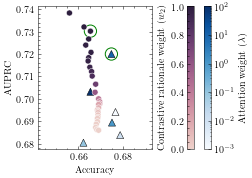

In [9]:
import matplotlib
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1)

performance_metric = "accuracy"
explainability_metric = "alternative_auprc"

table = []

# bert_attention

table_line = []

results = all_results["hatexplain_all-lime-bert_attention-2"]
results = sorted(results, key=lambda x: x['weight'])
weights = [result['weight'] for result in results]

x = []
y = []
for result in results:
    x.append(result['performance'][performance_metric])
    y.append(
        np.mean(
            filter_results(result['explainability'][explainability_metric])
        )
    )
good_result_index = good_result_map["hatexplain_all-lime-bert_attention-2"]
x_good = x[good_result_index]
y_good = y[good_result_index]
ax.scatter(x_good, y_good, s=150, facecolors='none', edgecolors='green')

table_line.append("BERT-HateXplain")
table_line.append(x_good*100)
table_line.append(y_good*100)
table_line.append(
    -np.mean(
        filter_results(
            results[good_result_index]['explainability']['sufficiency_aopc']
        )
    )
)
table_line.append(
    np.mean(
        filter_results(
            results[good_result_index]['explainability']['comprehensiveness_aopc']
        )
    )
)
table.append(table_line)

norm = plt.Normalize(0, max(weights))
cmap = sns.color_palette("Blues", as_cmap=True)
cmap_bert_attention = cmap
norm = matplotlib.colors.LogNorm(vmin=min(weights), vmax=max(weights))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

sns.scatterplot(
    x="Accuracy",
    y="AUPRC",
    data=pd.DataFrame({
        "Accuracy": x,
        "AUPRC": y,
    }),
    hue=weights,
    ax=ax,
    marker='^',
    s=50,
    palette=cmap,
    hue_norm=norm,
    edgecolor='black',
    linewidth=0.5,
)
fig.colorbar(
    sm,
    orientation="vertical",
    label="Attention weight ($\lambda$)",
    location="right",
    pad=-0.05,
)

# bert_128_fine_tuned

table_line = []

results = all_results["hatexplain_all-lime-bert_128_fine_tuned-2"]
results = sorted(results, key=lambda x: x['weight'])
results = results[1:]  # Remove the first result (cross-entropy weight = 0)
weights = [result['weight'] for result in results]
weights = [1 - weight for weight in weights]

x = []
y = []
for result in results:
    x.append(result['performance'][performance_metric])
    y.append(
        np.mean(
            filter_results(result['explainability'][explainability_metric])
        )
    )

good_result_index = good_result_map["hatexplain_all-lime-bert_128_fine_tuned-2"]
x_good = x[good_result_index]
y_good = y[good_result_index]
ax.scatter(x_good, y_good, s=150, facecolors='none', edgecolors='green')

table_line.append("Ours")
table_line.append(x_good*100)
table_line.append(y_good*100)
table_line.append(
    -np.mean(
        filter_results(
            results[good_result_index]['explainability']['sufficiency_aopc']
        )
    )
)
table_line.append(
    np.mean(
        filter_results(
            results[good_result_index]['explainability']['comprehensiveness_aopc']
        )
    )
)
table.append(table_line)

norm = plt.Normalize(0, 1)
cmap = sns.cubehelix_palette(as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(
    sm,
    orientation="vertical",
    label="Contrastive rationale weight ($w_2$)",
    location="right",
    pad=0.2,
)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('left')

sns.scatterplot(
    x="Accuracy",
    y="AUPRC",
    data=pd.DataFrame({
        "Accuracy": x,
        "AUPRC": y,
    }),
    hue=weights,
    ax=ax,
    hue_norm=norm,
    palette=cmap,
)
ax.set_aspect('equal', adjustable='datalim')

ax.legend_.remove()
plt.subplots_adjust(wspace=0.3)
plt.savefig(
    f"comparison_graphic.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
plt.close()

In [10]:
table_df = pd.DataFrame(table)
table_df.columns = ["Model", "Acc. %", "AUPRC %", "Suff.", "Comp."]
table_df = table_df.set_index("Model", inplace=False)
table_df = table_df.applymap(lambda x: f"{round(x, 2):.2f}")
table_df

,Acc. %,AUPRC %,Suff.,Comp.
Model,,,,
BERT-HateXplain,67.47,72.00,0.12,0.53
Ours,66.54,73.02,0.14,0.40


In [11]:
latex = table_df.to_latex()
latex = latex.replace("{lllll}", "{l|cccc}")
latex = latex.replace(r"\toprule", r"\hline")
latex = latex.replace(r"\midrule", r"\hline")
latex = latex.replace(r"\bottomrule", r"\hline")
latex = latex.replace(
    r"{} & Acc. \% & AUPRC \% & Suff. & Comp. \\",
    r"\textbf{Model} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{Suff.} & \textbf{Comp.} \\"
)
latex = latex.replace(
    r"Model           &        &         &       &       \\",
    "",
)
print(latex)

\begin{tabular}{l|cccc}
\hline
\textbf{Model} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{Suff.} & \textbf{Comp.} \\

\hline
BERT-HateXplain &  67.47 &   72.00 &  0.12 &  0.53 \\
Ours            &  66.54 &   73.02 &  0.14 &  0.40 \\
\hline
\end{tabular}

